In [8]:
# ================================
# Cell 1 — Imports & Configuration
# ================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from utils import generate_random_sales

# Display settings
pd.set_option("display.max_columns", None)

# Project constants
YEAR = 2025
START = f"{YEAR}-01-01"
END = f"{YEAR}-12-01"
OUTPUT_DIR = "data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42  # for reproducibility
product_cols = ["Product_A", "Product_B", "Product_C", "Product_D"]

print("Environment ready.")


Environment ready.


In [9]:
# ========================================
# Cell 2 — Generate & Save initial dataset
# ========================================

# Monthly dates (month start)
dates = pd.date_range(start=START, end=END, freq="MS")

# Random sales per product
product_a = generate_random_sales(50, 100, 12, seed=SEED)
product_b = generate_random_sales(30, 80, 12, seed=SEED + 1)
product_c = generate_random_sales(20, 60, 12, seed=SEED + 2)
product_d = generate_random_sales(10, 50, 12, seed=SEED + 3)

# Build dataframe
df_initial = pd.DataFrame({
    "Date": dates,
    "Product_A": product_a,
    "Product_B": product_b,
    "Product_C": product_c,
    "Product_D": product_d
})

# Save
df_initial.to_csv(f"{OUTPUT_DIR}/initial.csv", index=False)
df_initial


,Date,Product_A,Product_B,Product_C,Product_D
0,2025-01-01,88,34,40,21
1,2025-02-01,78,30,55,40
2,2025-03-01,64,79,23,13
3,2025-04-01,92,51,52,42
4,2025-05-01,57,46,40,41
5,2025-06-01,70,47,23,31
6,2025-07-01,88,57,43,45
7,2025-08-01,68,32,42,14
8,2025-09-01,72,76,45,25
9,2025-10-01,60,60,23,11


In [10]:
# =========================================
# Cell 3 — Build & Save final enhanced data
# =========================================

df = df_initial.copy()

# Add Month label
df["Month"] = df["Date"].dt.strftime("%Y-%m")

# Metrics
df["Total_Sales"] = df[product_cols].sum(axis=1)
df["Average_Sales"] = df[product_cols].mean(axis=1)

# Month-over-Month growth (%)
df["Month_over_Month_Growth"] = df["Total_Sales"].pct_change().fillna(0) * 100

# Quarter assignment
def to_quarter(month):
    if 1 <= month <= 3: return "Q1"
    if 4 <= month <= 6: return "Q2"
    if 7 <= month <= 9: return "Q3"
    return "Q4"

df["Quarter"] = df["Date"].dt.month.apply(to_quarter)

# Max/Min product per month
df["Max_Sales_Product"] = df[product_cols].idxmax(axis=1)
df["Min_Sales_Product"] = df[product_cols].idxmin(axis=1)

# Save final dataset
df.to_csv(f"{OUTPUT_DIR}/final.csv", index=False)
df


,Date,Product_A,Product_B,Product_C,Product_D,Month,Total_Sales,Average_Sales,Month_over_Month_Growth,Quarter,Max_Sales_Product,Min_Sales_Product
0,2025-01-01,88,34,40,21,2025-01,183,45.75,0.000000,Q1,Product_A,Product_D
1,2025-02-01,78,30,55,40,2025-02,203,50.75,10.928962,Q1,Product_A,Product_B
2,2025-03-01,64,79,23,13,2025-03,179,44.75,-11.822660,Q1,Product_B,Product_D
3,2025-04-01,92,51,52,42,2025-04,237,59.25,32.402235,Q2,Product_A,Product_D
4,2025-05-01,57,46,40,41,2025-05,184,46.00,-22.362869,Q2,Product_A,Product_C
5,2025-06-01,70,47,23,31,2025-06,171,42.75,-7.065217,Q2,Product_A,Product_C
6,2025-07-01,88,57,43,45,2025-07,233,58.25,36.257310,Q3,Product_A,Product_C
7,2025-08-01,68,32,42,14,2025-08,156,39.00,-33.047210,Q3,Product_A,Product_D
8,2025-09-01,72,76,45,25,2025-09,218,54.50,39.743590,Q3,Product_B,Product_D
9,2025-10-01,60,60,23,11,2025-10,154,38.50,-29.357798,Q4,Product_A,Product_D


In [11]:
# ==========================================
# Cell 4 — Quarterly pivot tables & summaries
# ==========================================

# Ensure correct quarter order
df["Quarter"] = pd.Categorical(df["Quarter"], categories=["Q1", "Q2", "Q3", "Q4"], ordered=True)

# Average sales per product per quarter
pivot_avg = df.pivot_table(
    index="Quarter",
    values=product_cols,
    aggfunc="mean",
    observed=False
).reset_index()

# Total sales per quarter
pivot_total = df.groupby("Quarter", observed=False)["Total_Sales"].sum().reset_index()

# Save combined output
with open(f"{OUTPUT_DIR}/output.csv", "w") as f:
    f.write("Average Sales per Product by Quarter\n")
    pivot_avg.to_csv(f, index=False)
    f.write("\nTotal Sales per Quarter\n")
    pivot_total.to_csv(f, index=False)

pivot_avg, pivot_total


(  Quarter  Product_A  Product_B  Product_C  Product_D
 0      Q1  76.666667  47.666667  39.333333  24.666667
 1      Q2  73.000000  48.000000  38.333333  38.000000
 2      Q3  76.000000  55.000000  43.333333  28.000000
 3      Q4  64.333333  47.666667  24.333333  17.666667,
   Quarter  Total_Sales
 0      Q1          565
 1      Q2          592
 2      Q3          607
 3      Q4          462)

In [12]:
# ================================
# Cell 5 — Key Performance Insights
# ================================

best_month_row = df.loc[df["Total_Sales"].idxmax()]
best_month = best_month_row["Month"]
best_month_total = best_month_row["Total_Sales"]

annual_totals = df[product_cols].sum()
best_product = annual_totals.idxmax()
best_product_total = annual_totals.max()

quarter_totals = df.groupby("Quarter", observed=False)["Total_Sales"].sum()
best_quarter = quarter_totals.idxmax()
best_quarter_total = quarter_totals.max()

insights = {
    "Best Month": (best_month, int(best_month_total)),
    "Best Product": (best_product, int(best_product_total)),
    "Best Quarter": (best_quarter, int(best_quarter_total))
}

insights


{'Best Month': ('2025-04', 237),
 'Best Product': ('Product_A', 870),
 'Best Quarter': ('Q3', 607)}

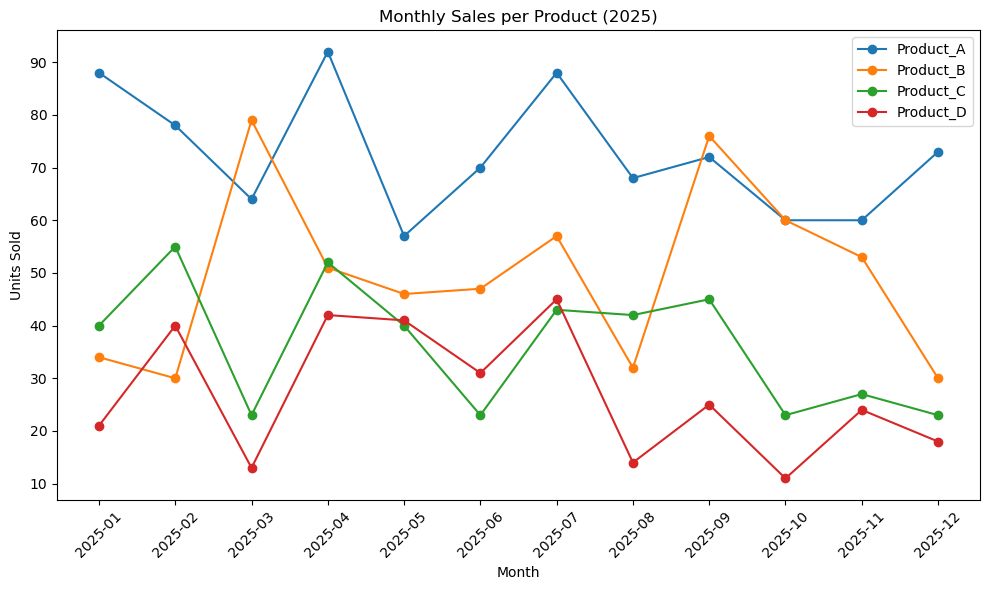

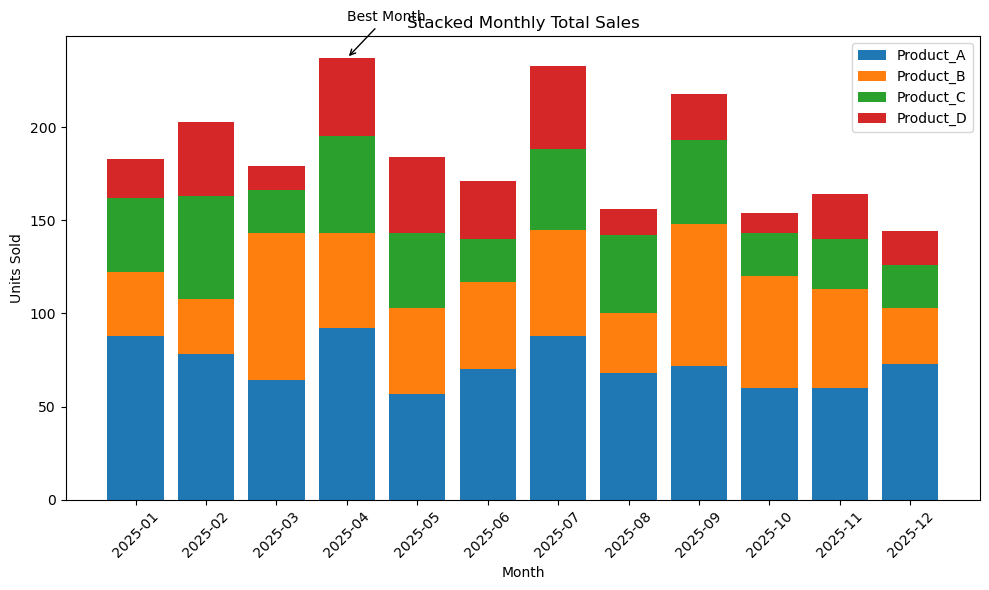

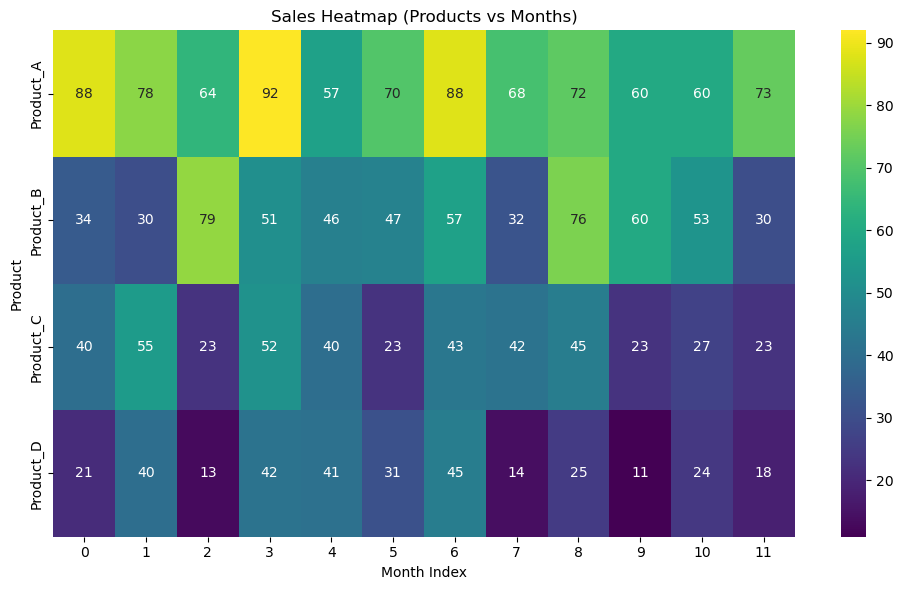

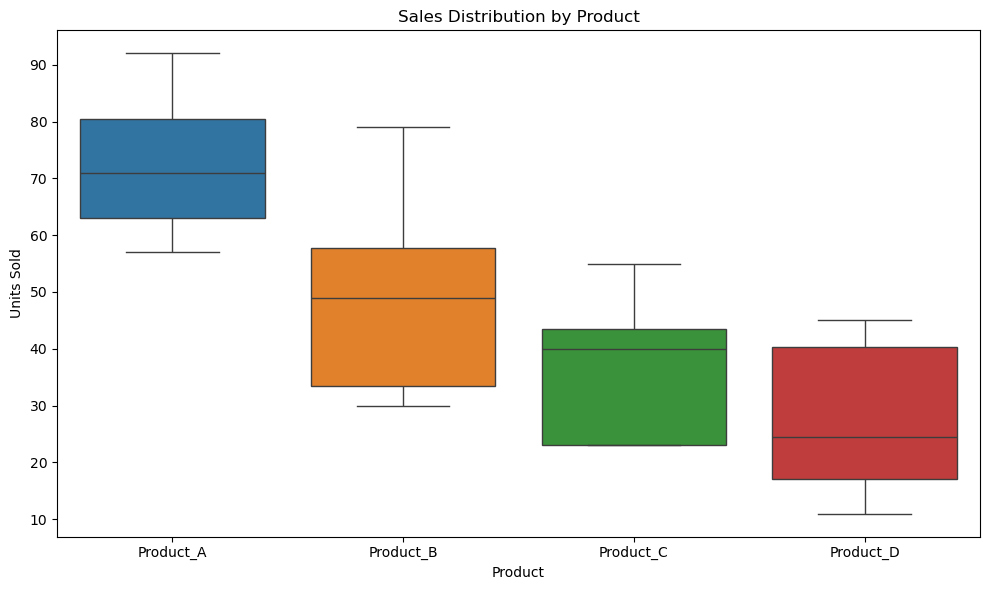

In [13]:
# =================================
# Cell 6 — Visualization Dashboard
# =================================

plt.style.use("default")  # ensure clean theme
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Line plot
plt.figure()
for col in product_cols:
    plt.plot(df["Month"], df[col], marker="o", label=col)
plt.title("Monthly Sales per Product (2025)")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Stacked bar chart
plt.figure()
bottom = np.zeros(len(df))
for col in product_cols:
    plt.bar(df["Month"], df[col], bottom=bottom, label=col)
    bottom += df[col].values

best_idx = df["Total_Sales"].idxmax()
plt.annotate("Best Month",
             xy=(best_idx, df.loc[best_idx, "Total_Sales"]),
             xytext=(best_idx, df["Total_Sales"].max() + 20),
             arrowprops=dict(arrowstyle="->"))

plt.title("Stacked Monthly Total Sales")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Heatmap
plt.figure()
sns.heatmap(df[product_cols].T, annot=True, fmt="d", cmap="viridis")
plt.title("Sales Heatmap (Products vs Months)")
plt.xlabel("Month Index")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

# 4. Boxplot
plt.figure()
sns.boxplot(data=df[product_cols])
plt.title("Sales Distribution by Product")
plt.xlabel("Product")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()
